##**Created By:  [Md. Zobayer Ibna Kabir](https://github.com/ZobayerAkib)**

#**Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Import Libraries**

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet_v2 import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras.applications import InceptionResNetV2
from keras.applications import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D
import itertools

#**Load data**

In [ ]:
data = np.load('/content/drive/MyDrive/Medical Image/PaperOne/image_data.npy',mmap_mode='r')
labels = np.load('/content/drive/MyDrive/Medical Image/PaperOne/labels.npy',mmap_mode='r')

In [ ]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (780, 224, 224, 3)
Labels shape: (780, 3)


#**Loading Images from the data**

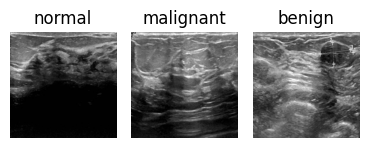

In [ ]:
unique_classes = np.unique(labels, axis=1)
# Create a dictionary to store one data sample from each class
class_samples = {}
# Map class indices to their corresponding names
class_names = {0: "benign", 1: "malignant", 2: "normal"}

# Select one data sample from each class
for class_label in unique_classes:
    class_indices = np.where(np.all(labels == class_label, axis=1))[0]
    class_samples[tuple(class_label)] = data[class_indices[0]]

# Plot the images in 2 rows
plt.figure(figsize=(5, 3))
for i, (class_label, image_data) in enumerate(class_samples.items()):
    class_index = np.argmax(class_label)  # Get the index of the class
    class_name = class_names[class_index]  # Get the corresponding class name
    plt.subplot(2, 4, i + 2)
    plt.imshow(image_data)
    plt.title(f'{class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

#**Data Splitting**

In [ ]:
# Split the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1,stratify=labels, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1,stratify=train_labels, random_state=42)

In [ ]:
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape)
print("val_labels shape:", val_labels.shape)
print("test_data shape:", test_data.shape)
print("test_labels shape:", test_labels.shape)

train_data shape: (631, 224, 224, 3)
train_labels shape: (631, 3)
val_data shape: (71, 224, 224, 3)
val_labels shape: (71, 3)
test_data shape: (78, 224, 224, 3)
test_labels shape: (78, 3)


#**Augmentation**

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

#**Callbacks For Model**

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 5,mode='max', min_lr = 1e-4,verbose = 1)
saved_model = '/content/drive/MyDrive/Medical Image/Saved Model/XceptionOne.keras'
model_chkpt = ModelCheckpoint(saved_model ,save_best_only = True, monitor = 'val_accuracy',verbose = 1)
callback_list = [model_chkpt, lr_reduce]

#**Xception Model**

In [ ]:
base_model = Xception(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#**Visualization the Neural Network Architecture**

In [ ]:
#Visualize the Neural Network Architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image as IPImage
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the architecture
from IPython.display import Image
Image('model_architecture.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.769377 to fit



#**Model Summary**


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,124,139 (80.58 MB)

 Trainable params: 21,069,611 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

#**Model Training**

In [ ]:
epochs = 50
batch_size = 8

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.5668 - loss: 0.9609
Epoch 1: val_accuracy improved from -inf to 0.56338, saving model to /content/drive/MyDrive/Medical Image/Saved Model/XceptionOne.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.5668 - loss: 0.9606 - val_accuracy: 0.5634 - val_loss: 1.3670 - learning_rate: 0.0010
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6041 - loss: 0.8856
Epoch 2: val_accuracy did not improve from 0.56338
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.6038 - loss: 0.8860 - val_accuracy: 0.5634 - val_loss: 9.5481 - learning_rate: 0.0010
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5985 - loss: 0.8452
Epoch 3: val_accuracy improved from 0.56338 to 0.59155, saving model to /content/drive/MyDrive/Medical Image/Saved Model/XceptionOne.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.5987 - loss: 0.8451 - val_accuracy: 0.5915 - val_loss: 1.6651 - learning_rate: 0.0010
Epo

In [ ]:
model= load_model('/content/drive/MyDrive/Medical Image/Saved Model/XceptionOne.keras')

#**Test Accuracy**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7582 - loss: 0.5498
Test Accuracy: 0.7820512652397156


#**Performance Metrics**

##Classification Report

In [ ]:
# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions and true labels to integer format
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculate the classification report
report = classification_report(true_labels, predicted_labels)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(report)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        44
           1       0.76      0.76      0.76        21
           2       0.69      0.85      0.76        13

    accuracy                           0.78        78
   macro avg       0.76      0.79      0.77        78
weighted avg       0.79      0.78      0.78        78



##Confusion Matrix

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, np.round(predicted_labels))

cm

array([[34,  5,  5],
       [ 5, 16,  0],
       [ 2,  0, 11]])

Confusion matrix, without normalization


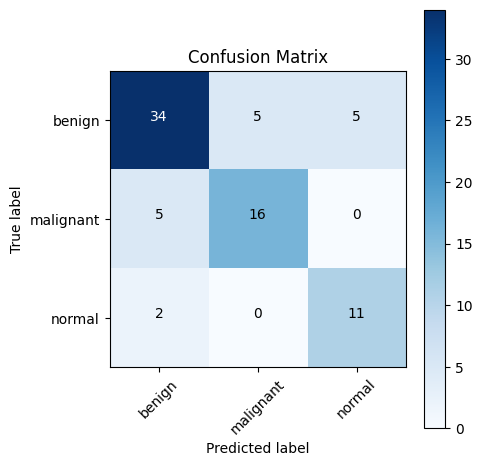

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Create the plot
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Set the format for the numbers (raw counts, not percentages)
    fmt = 'd'  # Use 'd' for displaying integers (raw counts)
    thresh = cm.max() / 2.

    # Annotate the cells with the number values
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = ["benign", "malignant", "normal"]

# Now plot the confusion matrix without normalization (raw counts)
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=False)


##ROC-AUC curve

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


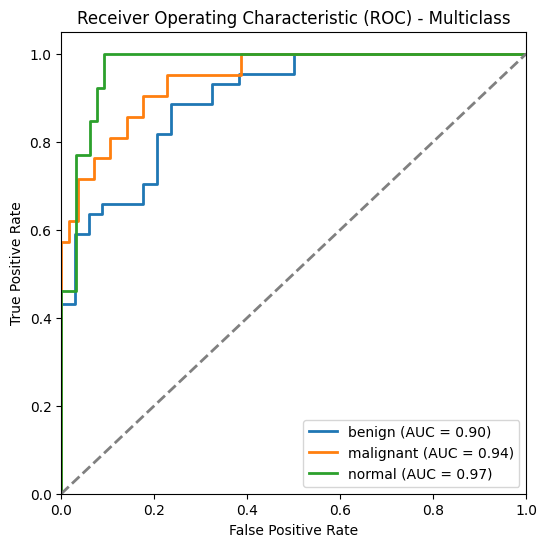

In [ ]:
# Define class names
class_names = [ "benign", "malignant", "normal"]

# Make predictions on the test data
predictions = model.predict(test_data)

# Get the number of classes
num_classes = test_labels.shape[1]

# Initialize a figure to plot ROC curves
plt.figure(figsize=(6, 6))

# Loop through each class
for class_index in range(num_classes):
    # Compute ROC curve and ROC AUC for the current class
    fpr, tpr, thresholds = roc_curve(test_labels[:, class_index], predictions[:, class_index])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for the current class
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[class_index]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random chance)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc='lower right')

# Display the plot
plt.show()

#**Explainable AI (XAI)**

In [ ]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow.python.client import device_lib
device_list = device_lib.list_local_devices()
gpus = [device.name for device in device_list if device.device_type == 'GPU']
print('TensorFlow recognized {} GPUs'.format(len(gpus)))

TensorFlow recognized 1 GPUs


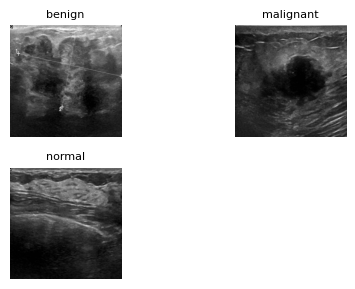

In [ ]:
image_titles = [ "benign", "malignant", "normal"]
num_images = len(image_titles)

# Convert one-hot encoded labels to integer labels
test_labels_int = np.argmax(test_labels, axis=1)
# Find the indices of the first image from each class
class_indices = [np.where(test_labels_int == i)[0][0] for i in range(len(image_titles))]

# Create an array to store the images
image_array = []

# Create subplots with 2 rows
num_rows = 2
num_cols = (num_images + 1) // num_rows
fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols
    ax[row, col].set_title(title, fontsize=8)

    # Display the image from test data
    img = test_data[class_indices[i]]
    image_array.append(img)  # Store the image in the array

    ax[row, col].imshow(img)
    ax[row, col].axis('off')

# Remove any empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

X = base_preprocess(np.array(image_array))

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0, 1, 2])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1][2])

Faster Scorecam

3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step


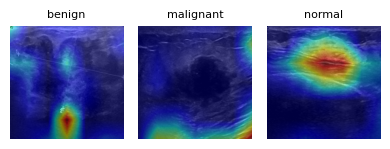

CPU times: user 14.2 s, sys: 605 ms, total: 14.8 s
Wall time: 49 s


In [ ]:
%%time
from matplotlib import cm
from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = 3

# Render
f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4, 4))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[row, col].set_title(title, fontsize=8)
    ax[row, col].imshow(image_array[i])
    ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[row, col].axis('off')

# Remove any empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    f.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


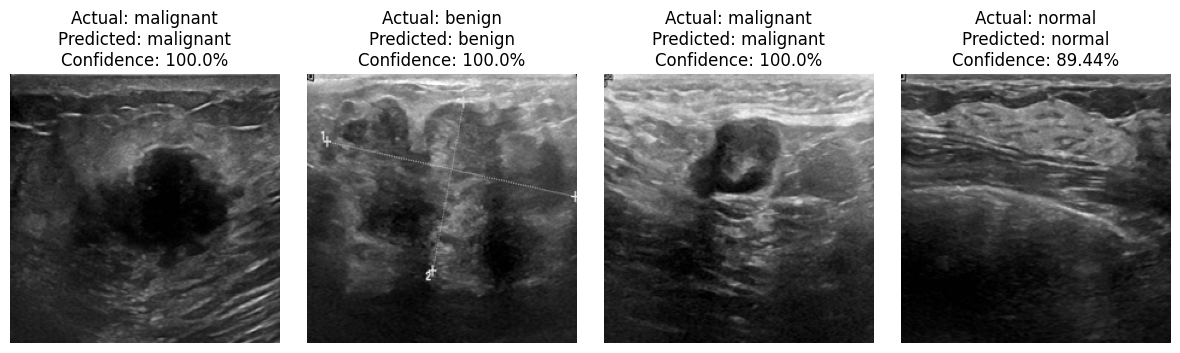

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming test_data contains images and test_labels contains the corresponding labels
images = test_data  # Test images
labels = test_labels  # Test labels

# Convert to TensorFlow dataset
batch_size = 4  # Set batch size to 4, as you have 4 images
test_ds = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

# Define class names
class_names = {0: "benign", 1: "malignant", 2: "normal"}

# Prediction function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch of 1 image
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])  # Get the index of the predicted class
    predicted_class = class_names[predicted_class_index]  # Get the class name
    confidence = round(100 * (np.max(predictions[0])), 2)  # Get the confidence percentage
    return predicted_class, confidence

# Plot predictions
plt.figure(figsize=(15, 15))
for images_batch, labels_batch in test_ds.take(1):
    for i in range(len(images_batch)):  # Loop through the 4 images
        ax = plt.subplot(5,5 , i + 1)  # Adjust subplot for 2x2 grid
        # Rescale image for display
        image_to_display = images_batch[i].numpy()  # Convert to numpy array
        if image_to_display.max() <= 1:  # If normalized, rescale to 0–255
            image_to_display = (image_to_display * 255).astype("uint8")

        plt.imshow(image_to_display)  # Display the image
        predicted_class, confidence = predict(model, images_batch[i])  # Get prediction and confidence
        actual_class_index = np.argmax(labels_batch[i].numpy())  # Get actual class from the one-hot encoded label
        actual_class = class_names[actual_class_index]  # Get the class name
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

plt.tight_layout()
plt.show()



In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=57e4a6be1de7a98ff943ea37e34c803f72066ba85cd8c0ac3d55546439ab74b6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

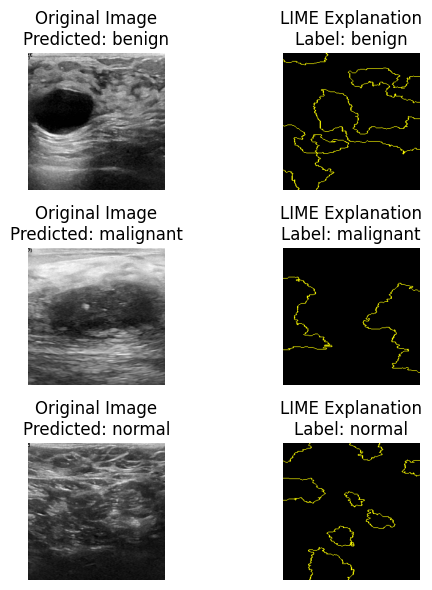

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define class names
class_names = {0: "benign", 1: "malignant", 2: "normal"}


# Define the prediction function
def predict(images):
    images = np.array(images)  # Convert to numpy array
    return model.predict(images)

# Paths to the images
image_paths = [
    '/content/drive/MyDrive/Medical Image/PaperOne/benign/benign (103).png',
    '/content/drive/MyDrive/Medical Image/PaperOne/malignant/malignant (1).png',
    '/content/drive/MyDrive/Medical Image/PaperOne/normal/normal (104).png'
]

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Set up the plot for displaying images and explanations
plt.figure(figsize=(6, 6))

# Loop through each image path and generate LIME explanations
for idx, image_path in enumerate(image_paths):
    # Load the image
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0  # Normalize
    image_batch = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Get the actual label from the prediction (if available from data)
    predictions = model.predict(image_batch)
    predicted_class_index = np.argmax(predictions[0])  # Get the index of the predicted class
    predicted_class = class_names[predicted_class_index]  # Map index to class name

    # Generate explanation for the image
    explanation = explainer.explain_instance(
        image_array,  # Input image (not batched)
        predict,      # Prediction function
        top_labels=3, # Number of labels to explain
        hide_color=0, # Hide background with black
        num_samples=1000  # Number of perturbations
    )

    # Visualize the explanation for the top predicted label
    top_label = explanation.top_labels[0]  # Get the top predicted label
    temp, mask = explanation.get_image_and_mask(
        label=top_label,  # Class label to explain
        positive_only=True,  # Show only positive contributions
        num_features=10,  # Number of superpixels
        hide_rest=False  # Show the rest of the image
    )

    # Display the original image and LIME explanation
    plt.subplot(3, 2, 2*idx + 1)  # Adjust for 3 rows, 2 columns
    plt.imshow(image_array)
    plt.title(f"Original Image\nPredicted: {predicted_class}")
    plt.axis("off")

    # LIME Explanation
    plt.subplot(3, 2, 2*idx + 2)
    plt.imshow(mark_boundaries(temp / 255.0, mask))  # Overlay explanation mask
    plt.title(f"LIME Explanation\nLabel: {class_names[top_label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()